# Financial Volatility Modelling

There are some time series where the variance changes consistently over time. In the context of financial time series, this would be called increasing or decreasing volatility.

In time series where the variance is increasing in a systematic way, such as an increasing trend, this property of the series is called heteroskedasticity. If the change in variance can be correlated over time, then it can be modeled using an autoregressive process, such as an ARCH.

Autoregressive Conditional Heteroskedasticity (ARCH) models explicitly allow modelling of the change in variance over time in a time series, something that classical ARMA models do not allow.

In this section we will present an example of esimating ARCH and GARCH models with Python. We will use the `arch_model` function from the `arch` [package](https://arch.readthedocs.io/en/latest/index.html). 

To install the package, follow the [documentation](https://pypi.org/project/arch/) - open your command prompt (as long as you selected to add anaconda to your `PATH` during the installation) and enter the following:

``conda install -c bashtage arch ``

If you do not have ana`conda`, use ``pip install arch``

Note that this package works on a 64-bit OS **only**.

In [1]:
#Import the required modules for vectors and matrix operations, data generation
import numpy as np
#Import the required modules for plot creation:
import matplotlib.pyplot as plt
#import the required modules for TimeSeries data generation:
import statsmodels.api as sm
#Import the required modules for test statistic calculation:
import statsmodels.stats as sm_stat
#Import the required modules for time series model estimation:
import statsmodels.tsa as smt
#Import Pandas
import pandas as pd

In [2]:
import arch as arch

you can read the documentation on `arch` with

In [3]:
arch.doc()

Other usefull functions:

In [4]:
def tsdisplay(y, figsize = (14, 8), title = "", lags = 20):
    tmp_data = pd.Series(y)
    fig = plt.figure(figsize = figsize)
    #Plot the time series
    tmp_data.plot(ax = fig.add_subplot(311), title = "$Time\ Series\ " + title + "$", legend = False)
    #Plot the ACF:
    sm.graphics.tsa.plot_acf(tmp_data, lags = lags, zero = False, ax = fig.add_subplot(323))
    plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the PACF:
    sm.graphics.tsa.plot_pacf(tmp_data, lags = lags, zero = False, ax = fig.add_subplot(324))
    plt.xticks(np.arange(1,  lags + 1, 1.0))
    #Plot the QQ plot of the data:
    sm.qqplot(tmp_data, line='s', ax = fig.add_subplot(325)) 
    plt.title("QQ Plot")
    #Plot the residual histogram:
    fig.add_subplot(326).hist(tmp_data, bins = 40, normed = 1)
    plt.title("Histogram")
    #Fix the layout of the plots:
    plt.tight_layout()
    plt.show()

In [5]:
def tsdiag(y, figsize = (14,8), title = "", lags = 10):
    #The data:
    tmp_data = pd.Series(y)
    #The Ljung-Box test results for the first k lags:
    tmp_acor = list(sm_stat.diagnostic.acorr_ljungbox(tmp_data, lags = lags, boxpierce = True))
    # get the p-values
    p_vals = pd.Series(tmp_acor[1])
    #Start the index from 1 instead of 0 (because Ljung-Box test is for lag values from 1 to k)
    p_vals.index += 1
    fig = plt.figure(figsize = figsize)
    #Plot the p-values:
    p_vals.plot(ax = fig.add_subplot(313), linestyle='', marker='o', title = "p-values for Ljung-Box statistic", legend = False)
    #Add the horizontal 0.05 critical value line
    plt.axhline(y = 0.05, color = 'blue', linestyle='--')
    # Annotate the p-value points above and to the left of the vertex
    x = np.arange(p_vals.size) + 1
    for X, Y, Z in zip(x, p_vals, p_vals):
        plt.annotate(round(Z, 4), xy=(X,Y), xytext=(-5, 5), ha = 'left', textcoords='offset points')
    plt.show()
    # Return the statistics:
    col_index = ["Ljung-Box: X-squared", "Ljung-Box: p-value", "Box-Pierce: X-squared", "Box-Pierce: p-value"]
    return pd.DataFrame(tmp_acor, index = col_index, columns = range(1, len(tmp_acor[0]) + 1))

In [6]:
# Suppress matplotlib's annoying deprecation warning
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category = matplotlib.cbook.mplDeprecation)

---

## ARCH: General Idea and Simulation

We can think of $\rm ARCH$ models as $\rm AR$ model analogue applied to the error variance of a time series $r_t$ (where $r_t$ are usually. More specifically, it models the variance at time $t$ as a function of the residual errors from a mean process.

For example, we define the following $\rm ARCH(1)$ process:

$
\begin{cases}
r_t &= \mu + \epsilon_t \\
\epsilon_t &= \sigma_t w_t,\quad w_t \sim WN(0, \sigma^2)\\
\sigma_t^2 &= \omega + \alpha_1 \epsilon^2_{t-1}
\end{cases}
$

In general, a volatility modelling includes the following components:

- $\mu$ - the **mean model**. This can be considered the *first component* in volatility model building. Examples include:
   - zero mean: $r_t = \epsilon_t$;
   - constant mean: $r_t = \mu + \epsilon_t$;
   - an $\rm AR(p)$ with constant: $r_t = \gamma + \sum_{j=1}^p \phi_{j} r_{t-j} + \epsilon_t$ 
   - more complex models, like an $\rm ARMA(p,q)$ process with exogeneous variables and so on.
   
- $\sigma_t^2 = ...$ - **a volatility model**, which is added to the mean model to capture time-varying volatility. In addition to $\rm ARCH$, other specifications are available, like: the constant variance, $\rm GARCH$, $\rm EGARCH$, $\rm IGARCH$, $\rm GJR-GARCH$, $\rm TGARCH$ and more.

- $w_t \sim WN(0, \sigma^2)$ - the distribution of $w_t$ is the final component of a volatility model. Examples include - standard normal, Student t, GED ([Generalized Error Distribution](https://en.wikipedia.org/wiki/Generalized_normal_distribution#Version_1)) and so on.

We will simulate an $\rm ARCH(1)$ process as follows:

In [7]:
np.random.seed(123)
#Define the sample size:
n = 2000
# Define the coefficients:
mu = 1.0
omega = 2.0
alpha = 0.5
# Generate the random shocks
w = np.random.normal(size = n)
#
# Generate the ARCH process:
r_t = np.array(mu + np.sqrt(omega) * w[0], ndmin = 1)
for j in range(1, n):
    r_t = np.append(r_t, mu + np.sqrt(omega + alpha * ((r_t[j-1] - mu)**2)) * w[j])

We can examine the series:

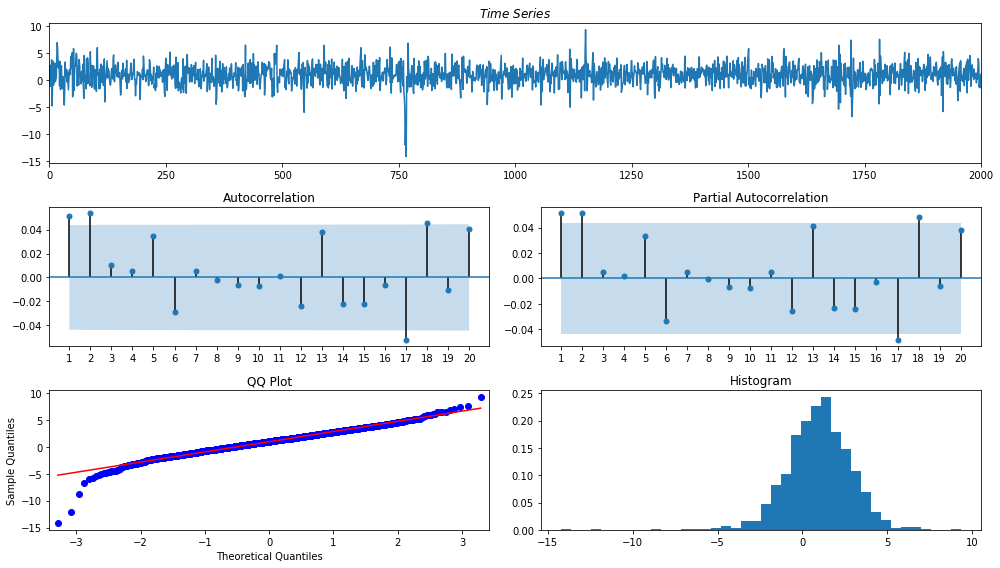

In [8]:
tsdisplay(r_t)

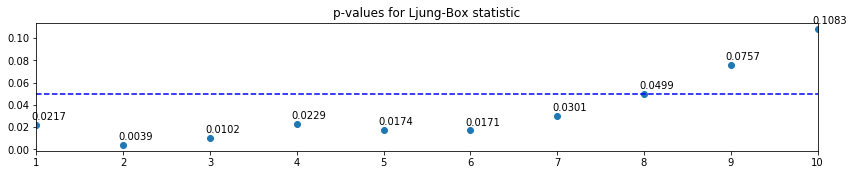

1          2          3          4          5   \
Ljung-Box: X-squared   5.266093  11.073378  11.292001  11.348124  13.728753   
Ljung-Box: p-value     0.021745   0.003940   0.010247   0.022918   0.017427   
Box-Pierce: X-squared  5.258201  11.053884  11.271961  11.327915  13.700221   
Box-Pierce: p-value    0.021844   0.003978   0.010343   0.023116   0.017630   

                              6          7          8          9          10  
Ljung-Box: X-squared   15.441068  15.502509  15.513726  15.599786  15.708086  
Ljung-Box: p-value      0.017090   0.030071   0.049893   0.075724   0.108299  
Box-Pierce: X-squared  15.405694  15.466858  15.478019  15.563606  15.671257  
Box-Pierce: p-value     0.017325   0.030459   0.050491   0.076573   0.109438

In [9]:
tsdiag(r_t)

The first lags appear to be correlated. Now let's plot the squared time series:

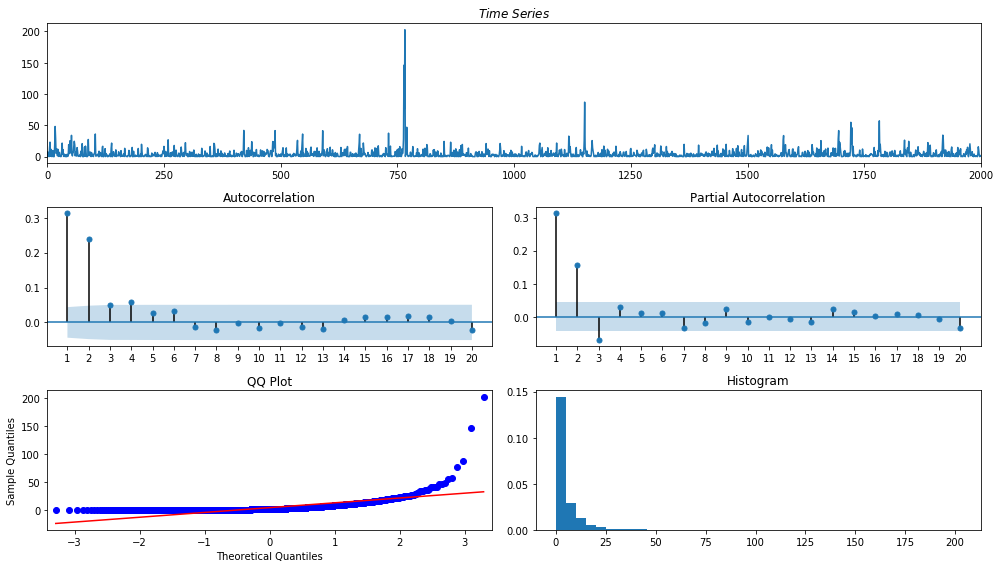

In [10]:
tsdisplay(r_t**2)

We see a strong autocorrelation, which may indicate the possibility of ARCH effects. 

If we wanted to estimate an ARCH model on this data, we would first have to create a mean model for the returns `r_t`. Then we should inspect the residuals - if their ACF and PACF plots show no autocorrelation but the squared residual ACF and PACF plots - show autocorrelation - we should create an ARCH model for the residuals.

**We leave this as an exercise and instead opt to show the detailed modelling steps for the more general, $\rm GARCH$ model. These same steps can also be applied to the $\rm ARCH$ model specification.**

----

## GARCH: simulation and model building example

A $\rm GARCH$ model can be thought of an an ARMA model analogue applied to the error variance of a time series.

We will consider the following $\rm GARCH(1, 1)$ example:

$
\begin{cases}
r_t &= \mu + \epsilon_t \\
\epsilon_t &= \sigma_t w_t \\
\sigma_t^2 &= \omega + \alpha_1 \epsilon^2_{t-1} + \beta_1 \sigma^2_{t-1}
\end{cases}
$

where $\mu = 1$, $\omega = 0.2$, $\alpha = 0.5$ and $\beta = 0.3$ and $w_t \sim \mathcal{N}(0, 1)$.

In [11]:
np.random.seed(1)
#Define the sample size:
n = 2000
# Define the coefficients:
mu = 1.0
omega = 0.2
alpha = 0.5
beta  = 0.3
# Generate the random shocks
w = np.random.normal(size = n)
sigma_sq = np.zeros_like(w)
#
# Generate the GARCH process:
sigma_sq[0] = omega
r_t = np.array(mu + np.sqrt(sigma_sq[0]) * w[0], ndmin = 1)
for j in range(1, n):
    sigma_sq[j] = omega + alpha * ((r_t[j-1] - mu)**2 + beta * sigma_sq[j-1])
    r_t = np.append(r_t, mu + np.sqrt(sigma_sq[j]) * w[j])

We will again examine the ACF's of the series:

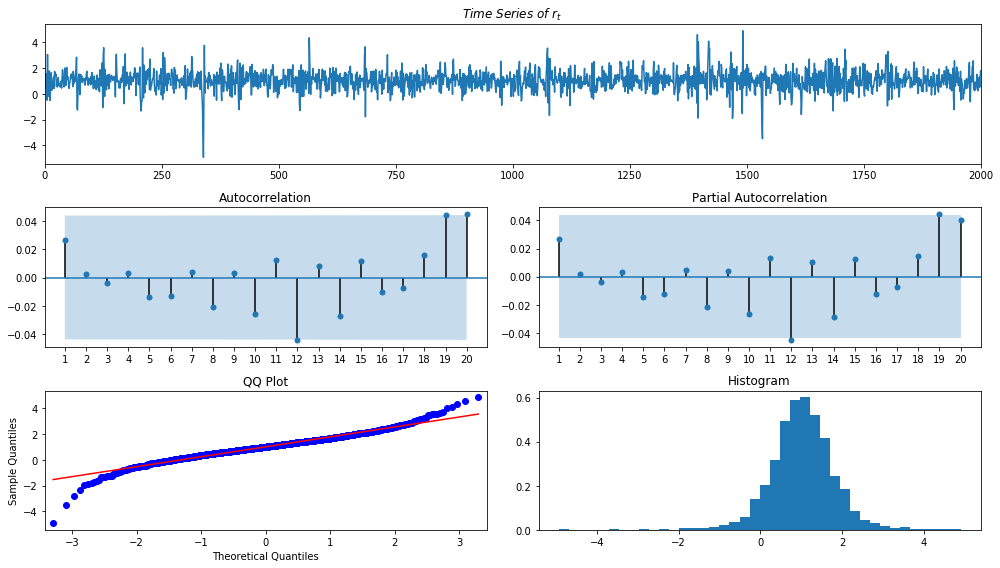

In [12]:
tsdisplay(r_t, title = "of\ r_t")

If we test for significant autocorrelations

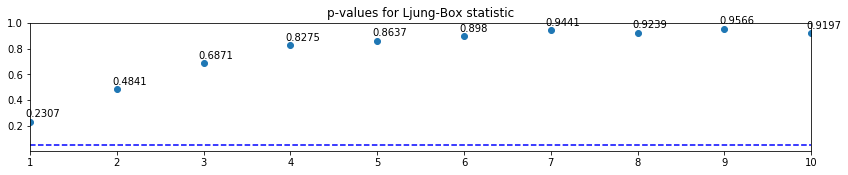

1         2         3         4         5   \
Ljung-Box: X-squared   1.436600  1.450969  1.479100  1.495282  1.893443   
Ljung-Box: p-value     0.230690  0.484090  0.687102  0.827477  0.863684   
Box-Pierce: X-squared  1.434448  1.448787  1.476848  1.492982  1.889751   
Box-Pierce: p-value    0.231040  0.484618  0.687624  0.827884  0.864180   

                             6         7         8         9         10  
Ljung-Box: X-squared   2.223409  2.258945  3.160586  3.181938  4.539475  
Ljung-Box: p-value     0.898048  0.944130  0.923879  0.956643  0.919747  
Box-Pierce: X-squared  2.218398  2.253774  3.150912  3.172146  4.521547  
Box-Pierce: p-value    0.898557  0.944471  0.924533  0.957077  0.920768

In [13]:
tsdiag(r_t)

It would appear that our series is $WN$.

However, we do note that if $\epsilon_t \sim WN$, then their squared values should not be autocorrelated as well. We will test this

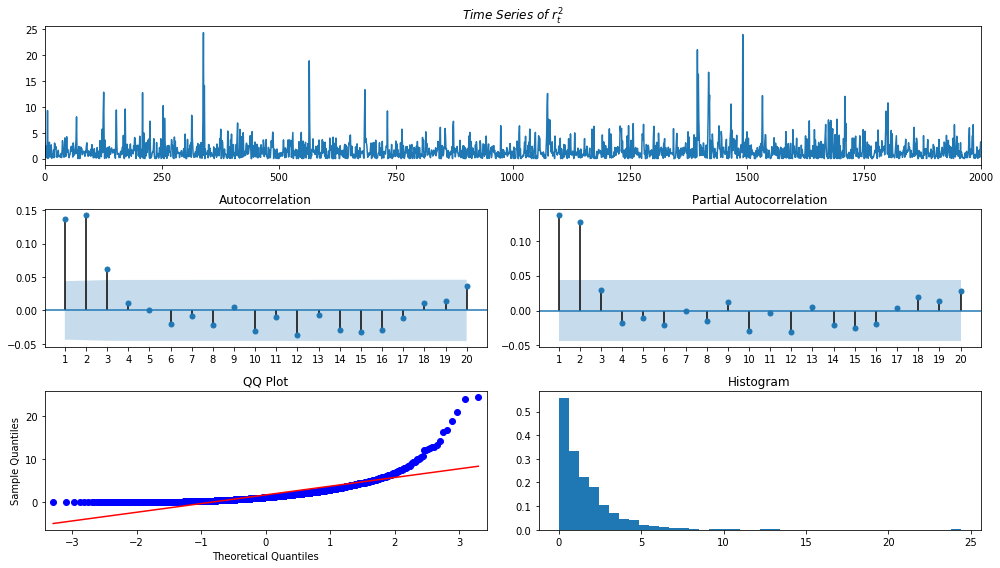

In [14]:
tsdisplay(r_t**2, title = "of\ r_t^2")

We see that the autocorrelation is significant, which indicates ARCH effects. 

---
---

In comparison, a simple WN (in this case, a standard normal) process does not have this property:

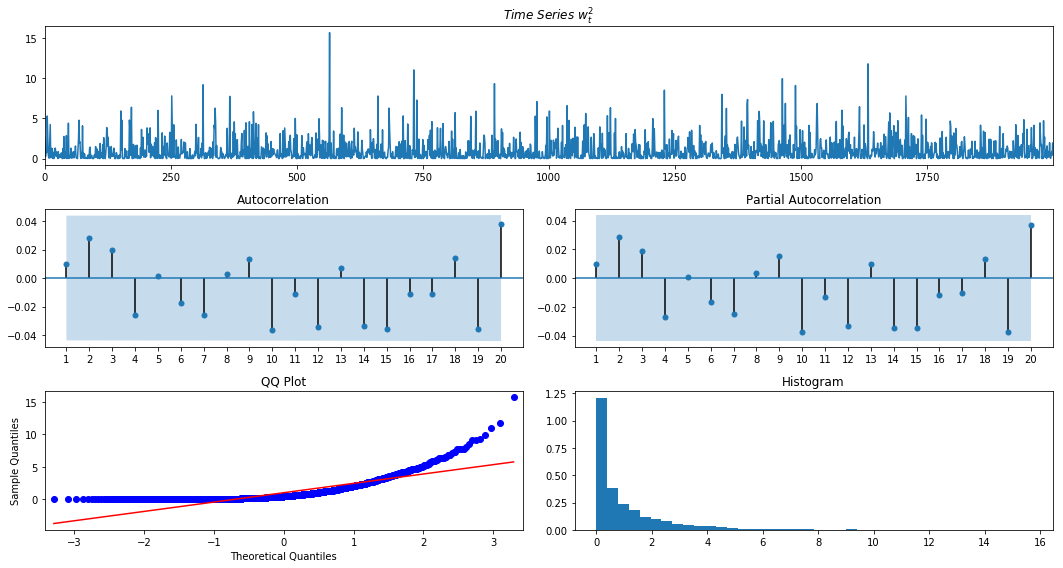

In [15]:
tsdisplay(w**2, title = "w_t^2", figsize = (15, 8))

---
---

We will supress additional warning messages to make it easier to read the output. These messages include:
    
- `FutureWarning`: 
        "Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. 
        In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result."
  This is a warning specific to `statsmodels` estimation, which will hopefully be adressed in a package update.

- `RuntimeWarning`: 
        "Invalid value encountered in true_divide newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()"
  This is again a warning in `statsmodels` for some lag order combinations. Again, the hope is that it will be adressed in the future.

- `HessianInversionWarning`:
        "Inverting hessian failed, no bse or cov_params available"
  This is again a warning in `statsmodels` for some lag order combinations.

- `ConvergenceWarning`:
        "Maximum Likelihood optimization failed to converge. Check mle_retvals"
  This is again a warning in `statsmodels` for some lag order combinations, which do not lead ot a convergence in the maximum likelihood function.

In [16]:
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)
warnings.filterwarnings("ignore", category = sm.tools.sm_exceptions.HessianInversionWarning)
warnings.filterwarnings("ignore", category = sm.tools.sm_exceptions.ConvergenceWarning)

---

### (1) Specifying a mean model

We begin by creating the model for the mean by looping through all possible $\rm ARMA(p, q)$ model combinations with $p_\max=q_\max=1$.

In [17]:
# Specify the best AIC - default is infinite - so anything lower is better
best_aic = np.inf
# Specify the best order
best_order = None
# Specify the best model
best_mdl = None
# Loop through different (p, q) combinations, starting from ARMA(0, 0), to ARMA(1, 1)
pq_rng = range(2) # range(5) would be [0,1,2,3,4]
for i in pq_rng:
    for j in pq_rng:
        try:
            #print("Fitting an ARMA(" + str(i), ", " + str(j) + ") model")
            tmp_mdl = smt.api.ARIMA(r_t, order = (i,0,j)).fit(method = 'mle', trend = 'c')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, 0, j)
                best_mdl = tmp_mdl
                print("Fitted an ARMA(" + str(i), ", " + str(j) + ") model - it was better")
            else:
                print("Fitted an ARMA(" + str(i), ", " + str(j) + ") model - it was worse")
        except: continue

Fitted an ARMA(0 , 0) model - it was better
Fitted an ARMA(0 , 1) model - it was worse
Fitted an ARMA(1 , 0) model - it was worse
Fitted an ARMA(1 , 1) model - it was worse


In [18]:
best_aic

4648.563915165161

In [19]:
print(best_mdl.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0193      0.017     58.988      0.000       0.985       1.053


We could have used an already established function to automatically select the order:

In [20]:
mdl_auto = sm.tsa.stattools.arma_order_select_ic(r_t, ic = 'bic', trend = 'c', max_ar = 4, max_ma = 4)

In [21]:
print(mdl_auto)

{'bic':              0            1            2            3            4
0  4659.765720  4665.937976  4673.522338  4681.092451  4688.665073
1  4665.931050  4673.525965  4681.087045  4688.655576  4696.218524
2  4673.524263  4680.685774  4684.166055          NaN  4698.189203
3  4681.094948  4688.047263  4693.808986  4699.887352  4703.541366
4  4688.677420  4693.262785  4698.164081  4703.602001  4707.921521, 'bic_min_order': (0, 0)}


In [22]:
print(mdl_auto.bic_min_order)

(0, 0)


We chose our manual specification to highlight that we can always specify our own automated procedures. They may not be exactly as the ones readily provided in the packages, but we may not always need very generalized methods.

---

Note that sometimes having common roots results in `NaN` values in estimated parameters [link](https://stats.stackexchange.com/questions/203142/na-in-arima-model-is-it-suggest-that-the-model-is-over-fit).

---

As we have seen from the ACF and PACF plot of $r_t$, there is no need to create an $\rm ARMA$ model for the mean model and we got the same results from our $\rm ARMA$ order selection code.

---

### (2) Checking for $\rm ARCH$ effects

In order to test for **$\rm ARCH$ effects,** we need to calculate the residuals $\widehat{e}_t = r_t - \widehat{r}_t$

In [23]:
resids = best_mdl.resid

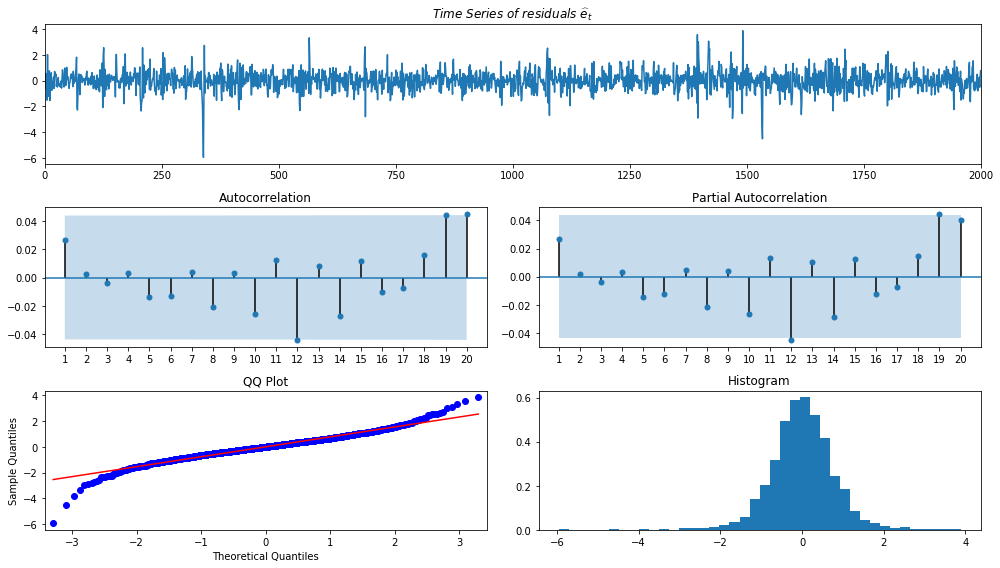

In [24]:
tsdisplay(resids, title = "of\ residuals\ \widehat{e}_t")

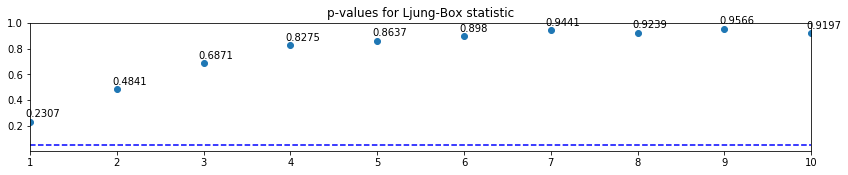

1         2         3         4         5   \
Ljung-Box: X-squared   1.436600  1.450969  1.479100  1.495282  1.893443   
Ljung-Box: p-value     0.230690  0.484090  0.687102  0.827477  0.863684   
Box-Pierce: X-squared  1.434448  1.448787  1.476848  1.492982  1.889751   
Box-Pierce: p-value    0.231040  0.484618  0.687624  0.827884  0.864180   

                             6         7         8         9         10  
Ljung-Box: X-squared   2.223409  2.258945  3.160586  3.181938  4.539475  
Ljung-Box: p-value     0.898048  0.944130  0.923879  0.956643  0.919747  
Box-Pierce: X-squared  2.218398  2.253774  3.150912  3.172146  4.521547  
Box-Pierce: p-value    0.898557  0.944471  0.924533  0.957077  0.920768

In [25]:
tsdiag(resids)

The residuals no not exhibit any significant autocorrelation, but their squared values:

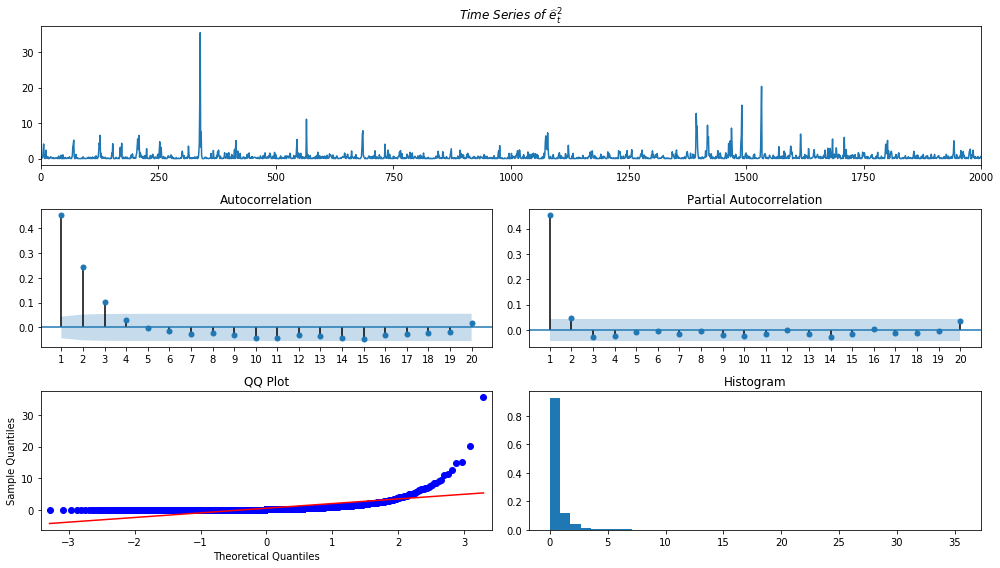

In [26]:
tsdisplay(resids**2, title = "of\ \widehat{e}_t^2")

exhibit significant autocorrelations. This can again be verified via Ljung-Box test:

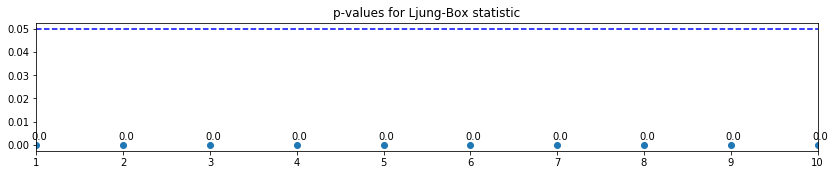

1              2              3   \
Ljung-Box: X-squared   4.118510e+02   5.306804e+02   5.521659e+02   
Ljung-Box: p-value     1.449457e-91  5.810637e-116  2.357527e-119   
Box-Pierce: X-squared  4.112339e+02   5.298258e+02   5.512577e+02   
Box-Pierce: p-value    1.974895e-91  8.908274e-116  3.709561e-119   

                                  4              5              6   \
Ljung-Box: X-squared    5.537575e+02   5.537961e+02   5.542147e+02   
Ljung-Box: p-value     1.573765e-118  1.936009e-117  1.742653e-116   
Box-Pierce: X-squared   5.528445e+02   5.528829e+02   5.532999e+02   
Box-Pierce: p-value    2.480182e-118  3.048761e-117  2.744299e-116   

                                  7              8              9   \
Ljung-Box: X-squared    5.554377e+02   5.563951e+02   5.581936e+02   
Ljung-Box: p-value     9.540885e-116  5.494701e-115  1.948741e-114   
Box-Pierce: X-squared   5.545174e+02   5.554700e+02   5.572586e+02   
Box-Pierce: p-value    1.505355e-115  8.682933e-115  3.092030e-114   

                                  10  
Ljung-Box: X-squared    5.616128e+02  
Ljung-Box: p-value     2.930530e-114  
Box-Pierce: X-squared   5.606574e+02  
Box-Pierce: p-value    4.693293e-114

In [27]:
tsdiag(resids**2)

Looking at the PACF plot of the squared residuals, $\widehat{e}_t^2$, we see that the first (and possibly, second?) lag is significantly different from zero, so we would need to specify an $\rm ARCH(1)$ model.

---

### (3) Specifying a volatility model and performing a joint estimation of the mean and volatility equations

We will further assume that the underlying shocks are normal, $w_t \sim \mathcal{N}(0, \sigma^2)$.

- The mean equation

In [28]:
mdl_arch = arch.univariate.ConstantMean(r_t)

- the volatility equation

In [29]:
mdl_arch.volatility = arch.univariate.ARCH(1)

- the shock distribution

In [30]:
mdl_arch.distribution = arch.univariate.Normal()

Now we can estimate the model coefficients:

In [31]:
mdl_arch_fit = mdl_arch.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 2063.9282348989996
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2063.8157793994865
Iteration:      3,   Func. Count:     23,   Neg. LLF: 2063.8022629924844
Iteration:      4,   Func. Count:     30,   Neg. LLF: 2063.6731746227806
Iteration:      5,   Func. Count:     35,   Neg. LLF: 2063.673021823548
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2063.6730218238563
            Iterations: 5
            Function evaluations: 35
            Gradient evaluations: 5


We can examine the model estimates:

In [32]:
print(mdl_arch_fit.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                       ARCH   Log-Likelihood:               -2063.67
Distribution:                  Normal   AIC:                           4133.35
Method:            Maximum Likelihood   BIC:                           4150.15
                                        No. Observations:                 2000
Date:                Sat, Mar 02 2019   Df Residuals:                     1997
Time:                        23:08:11   Df Model:                            3
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.0141  1.269e-02     79.901      0.000 [  0.989,  1.03

$
\begin{cases}
r_t &= 1.0141 + \epsilon_t \\
\epsilon_t &= \sigma_t w_t \\
\sigma_t^2 &= 0.2746 + 0.5270 \epsilon^2_{t-1}
\end{cases}
$

We can look at the coefficients and see that they are similar to the ones we used to generate the series (the true values were $\mu = 1$, $\omega = 0.2$, $\alpha = 0.5$):

In [33]:
print(mdl_arch_fit.params)

mu          1.014073
omega       0.274569
alpha[1]    0.526976
Name: params, dtype: float64


Note that we have estimated an $\rm ARCH$ model, so we have no $\beta$ parameter.

We can also view the $\rm AIC$ and $\rm BIC$ values:

In [34]:
print(pd.DataFrame([mdl_arch_fit.aic, mdl_arch_fit.bic], index = ["AIC", "BIC"], columns = ["ARCH"]).T)

              AIC          BIC
ARCH  4133.346044  4150.148751


---

- If we wanted to estimate a $\rm GARCH(1, 1)$ model, we would need to specify as follows:

In [35]:
mdl_garch = arch.univariate.ConstantMean(r_t)
mdl_garch.volatility = arch.univariate.GARCH(1, 0, 1)
mdl_garch.distribution = arch.univariate.Normal()

Then. the estimated model is:

In [36]:
mdl_garch_fit = mdl_garch.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2109.82885006753
Iteration:      2,   Func. Count:     16,   Neg. LLF: 2109.662128949584
Iteration:      3,   Func. Count:     23,   Neg. LLF: 2079.9254071764544
Iteration:      4,   Func. Count:     30,   Neg. LLF: 2074.1544459915485
Iteration:      5,   Func. Count:     37,   Neg. LLF: 2060.8541827726026
Iteration:      6,   Func. Count:     44,   Neg. LLF: 2052.451514595776
Iteration:      7,   Func. Count:     51,   Neg. LLF: 2048.854000342623
Iteration:      8,   Func. Count:     58,   Neg. LLF: 2047.7208398743273
Iteration:      9,   Func. Count:     64,   Neg. LLF: 2047.4171635170721
Iteration:     10,   Func. Count:     70,   Neg. LLF: 2047.3865316526096
Iteration:     11,   Func. Count:     76,   Neg. LLF: 2047.3831321330633
Iteration:     12,   Func. Count:     82,   Neg. LLF: 2047.3830591941799
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2047.3830585248247
            Iterati

In [37]:
print(mdl_garch_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -2047.38
Distribution:                  Normal   AIC:                           4102.77
Method:            Maximum Likelihood   BIC:                           4125.17
                                        No. Observations:                 2000
Date:                Sat, Mar 02 2019   Df Residuals:                     1996
Time:                        23:08:11   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             1.0155  1.247e-02     81.423      0.000 [  0.991,  1.04

$
\begin{cases}
r_t &= 1.0155 + \epsilon_t \\
\epsilon_t &= \sigma_t w_t \\
\sigma_t^2 &= 0.1809 + 0.5118 \epsilon^2_{t-1} + 0.1924 \sigma^2_{t-1}
\end{cases}
$

The true values were: $\mu = 1$, $\omega = 0.2$, $\alpha = 0.5$ and $\beta = 0.3$. The $\widehat{\beta}$ estimate is not as close to the true value as $\widehat{\mu}$, $\widehat{\alpha}$ and $\widehat{\omega}$.

Note the $\rm AIC$ and $\rm BIC$

In [38]:
print(pd.DataFrame([mdl_garch_fit.aic, mdl_garch_fit.bic], index = ["AIC", "BIC"], columns = ["GARCH"]).T)

               AIC          BIC
GARCH  4102.766117  4125.169727


Note that the $\rm AIC$ and $\rm BIC$ values are **smaller** than the ones for the $\rm ARCH$ model, indicating that this is a better model.

---
---

- If we wanted to specify an autoregressive process for the mean and estimate, say a $\rm AR(1)-GARCH(1, 1)$ model, we would do the following

In [39]:
mdl_ar_garch = arch.univariate.ARX(r_t, lags = 1)

In [40]:
mdl_ar_garch.volatility = arch.univariate.GARCH(1, 0, 1)

In [41]:
mdl_ar_garch.distribution = arch.univariate.Normal()

Then the estiamted model is:

In [42]:
mdl_ar_garch_fit = mdl_ar_garch.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 2109.5837134396315
Iteration:      2,   Func. Count:     18,   Neg. LLF: 2109.1010104352763
Iteration:      3,   Func. Count:     29,   Neg. LLF: 2108.349432778391
Iteration:      4,   Func. Count:     37,   Neg. LLF: 2078.7188433505657
Iteration:      5,   Func. Count:     45,   Neg. LLF: 2073.0395569273196
Iteration:      6,   Func. Count:     53,   Neg. LLF: 2059.7823795823974
Iteration:      7,   Func. Count:     61,   Neg. LLF: 2051.339040467455
Iteration:      8,   Func. Count:     69,   Neg. LLF: 2047.7834230337362
Iteration:      9,   Func. Count:     77,   Neg. LLF: 2046.6801648986202
Iteration:     10,   Func. Count:     84,   Neg. LLF: 2046.342863757498
Iteration:     11,   Func. Count:     91,   Neg. LLF: 2046.322370518488
Iteration:     12,   Func. Count:     98,   Neg. LLF: 2046.3208415270537
Iteration:     13,   Func. Count:    105,   Neg. LLF: 2046.3207937515638
Optimization terminated successfully.    (Exit mode 0)


In [43]:
print(mdl_ar_garch_fit.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:                        AR   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -2046.32
Distribution:                  Normal   AIC:                           4102.64
Method:            Maximum Likelihood   BIC:                           4130.64
                                        No. Observations:                 1999
Date:                Sat, Mar 02 2019   Df Residuals:                     1994
Time:                        23:08:12   Df Model:                            5
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const           1.0214  2.680e-02     38.112      0.

We can extract the parameters and round them to 4 digits:

In [44]:
np.round(mdl_ar_garch_fit.params, 4)

Const       1.0214
y[1]       -0.0061
omega       0.1812
alpha[1]    0.5117
beta[1]     0.1920
Name: params, dtype: float64

So, the $AR(1)-GARCH(1,1)$ model is:

$
\begin{cases}
r_t &= 1.0214 - 0.0061 r_{t-1} + \epsilon_t \\
\epsilon_t &= \sigma_t w_t \\
\sigma_t^2 &= 0.1812 + 0.5117 \epsilon^2_{t-1} + 0.1920 \sigma^2_{t-1}
\end{cases}
$

Note that the mean and volatility parameters are similar to the $\rm GARCH(1,1)$ model, with an additional $\widehat{\phi} = -0.0061$ autoregression coefficient in the mean equation.

If we look at the $\rm AIC$ and $\rm BIC$ values:

In [45]:
print(pd.DataFrame([mdl_ar_garch_fit.aic, mdl_ar_garch_fit.bic], index = ["AIC", "BIC"], columns = ["AR-GARCH"]).T)

                  AIC          BIC
AR-GARCH  4102.641588  4130.643599


We can compare with the $\rm GARCH(1, 1)$ model

In [46]:
print(pd.DataFrame([mdl_ar_garch_fit.aic - mdl_garch_fit.aic, mdl_ar_garch_fit.bic - mdl_garch_fit.bic], index = ["AIC", "BIC"], columns = ["Difference"]).T)

                AIC       BIC
Difference -0.12453  5.473872


We see that the $\rm AIC$ is slightly lower, but $\rm BIC$ is larger. Furthermore, the increase in $\rm BIC$ is larger than the decrease in $\rm AIC$. Finally, since $\rm BIC$ penalizes model complexity more heavily than $\rm AIC$, we conclude that the $AR(1)-GARCH(1, 1)$ model is not better than the $\rm GARCH(1, 1)$ model.

Finally, if we wanted, we could specify other distributions for the shocks, like Student's $t$ with `arch.univariate.StudentsT()`.

---
---

---

### (4) Model residual checking

Finally, we examine the **standardized** residuals to make sure that there are no more $\rm ARCH$ effects (nor any autocorrelation). The standardized residuals can be computed by dividing the residuals by the conditional volatility. 

In [47]:
std_resid = mdl_arch_fit.resid / mdl_arch_fit.conditional_volatility

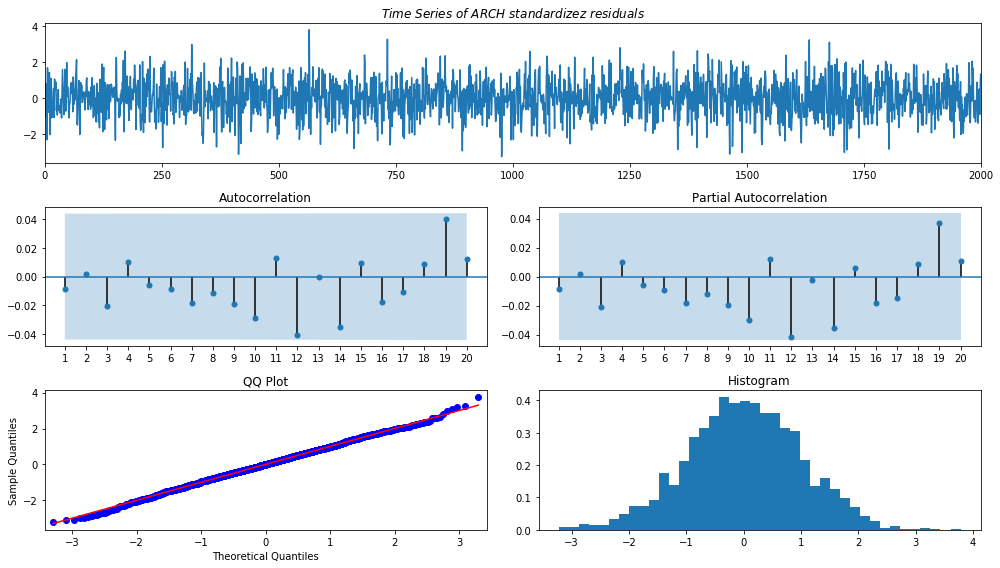

In [48]:
tsdisplay(std_resid, title = 'of\ ARCH\ standardizez\ residuals')

There are no autocorrelations in the standardized residuals.

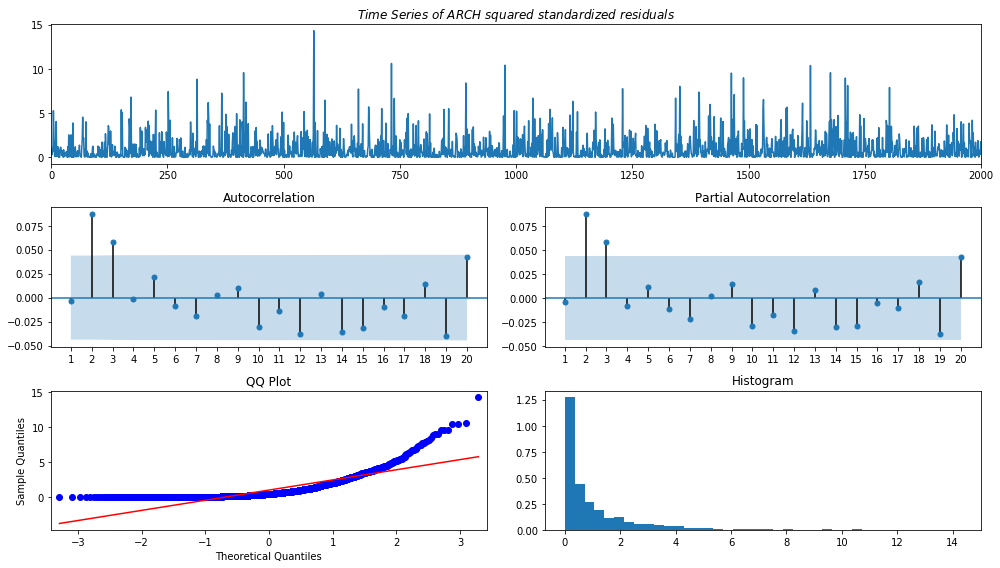

In [49]:
tsdisplay(std_resid**2, title = 'of\ ARCH\ squared\ standardized\ residuals')

We see that there are some $\rm ARCH$ effects still remaining. So our specified $ARCH(1)$ model **does not capture all of the ARCH effects**.

Our $\rm GARCH(1, 1)$ model, on the other hand:

In [50]:
std_resid = mdl_garch_fit.resid / mdl_garch_fit.conditional_volatility

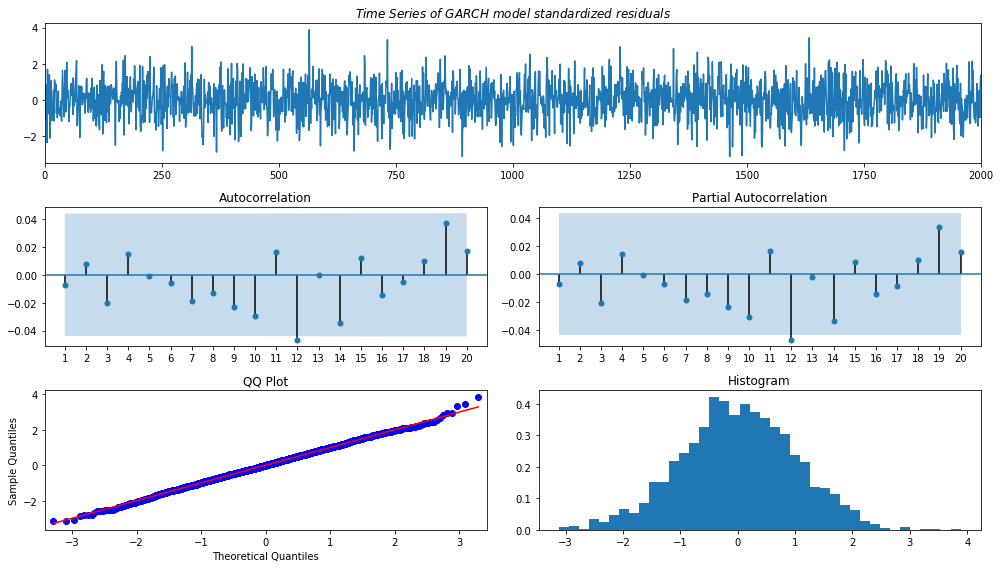

In [51]:
tsdisplay(std_resid, title = 'of\ GARCH\ model\ standardized\ residuals')

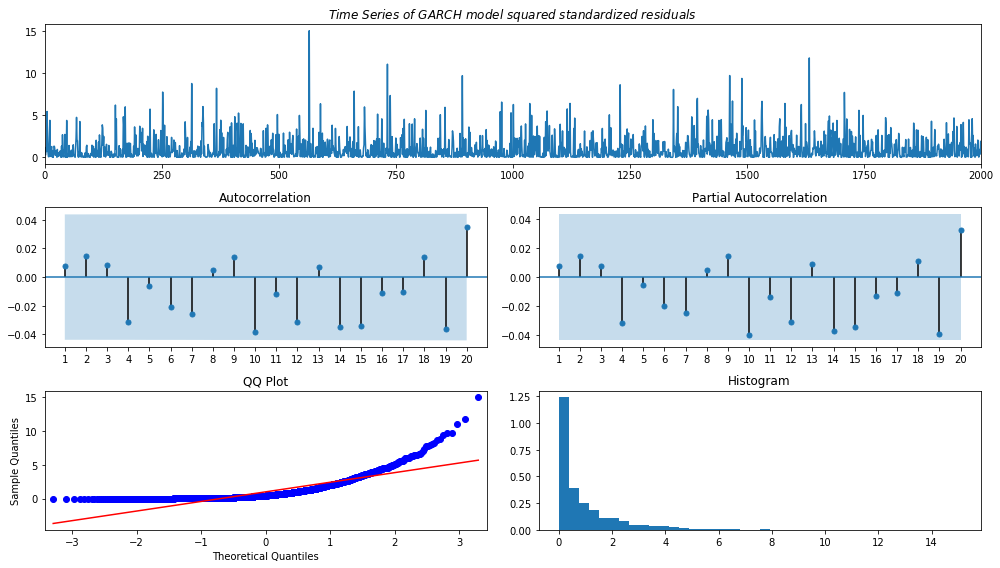

In [52]:
tsdisplay(std_resid**2, title = 'of\ GARCH\ model\ squared\ standardized\ residuals')

We see that the $\rm GARCH$ model standardized residuals do not exhibit any autocorrelation, and they do not have any more $\rm ARCH$ effects. 

**So, the $\rm GARCH(1, 1)$ model is adequate.**

----
----

Take note that for an $AR(1)-GARCH(1,1)$ processes the first residual will not be available:

In [53]:
mdl_ar_garch_fit.resid

array([        nan, -0.440719  , -0.33765257, ..., -0.50011222,
        0.37027425,  0.78319006])

which is to be expected, since autoregressive processes require past values, so the first observation will not have fitted values, due to not having any more past values. For higher order $\rm AR$ mean equation processes a larger number of initial value residuals will not be available.

----
----

---

### (5) Forecasting

After verifying that the specified model is adequate, we can predict the future values of:

- the return, $\widehat{r}_t$;
- the volatility, $\widehat{\sigma}^2$;

We can plot the returns and their [two-sigma confidence interval](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule). We will plot the last 100 observations:

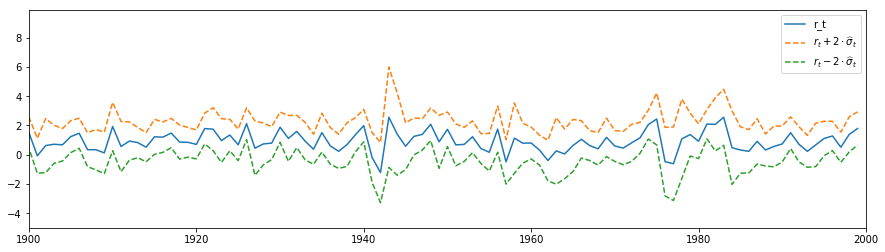

In [54]:
plt.figure(figsize = (15, 4))
plt.plot(r_t, label = "r_t")
plt.plot(r_t + 2 * mdl_garch_fit.conditional_volatility, linestyle ="--", label = "$r_t + 2 \cdot \widehat{\sigma}_t$")
plt.plot(r_t - 2 * mdl_garch_fit.conditional_volatility, linestyle ="--", label = "$r_t - 2 \cdot \widehat{\sigma}_t$")
# Custom start and end for the x-axis
plt.xlim(1900, len(r_t))
# Custom start for the y-axis
plt.ylim(-5)
plt.legend()
plt.show()

Using the fact that $\mathbb{E}(\epsilon^2_{t+1}) = \sigma^2_{t+1}$, we can recursively apply this relationship to create the following forecasts:

- a one-step ahead variance forecast for a $GARCH(1, 1)$ model is:

$
\begin{aligned}
\sigma^2_{t+1} & = \omega + \alpha \epsilon_t^2 + \beta \sigma^2_{t-1} 
\end{aligned}
$

- a $h$-step ahead variance forecast for a $GARCH(1, 1)$ model is:

$
\begin{aligned}
   \sigma^2_{t+h} & = \omega + \alpha  E_{t}[\epsilon_{t+h-1}^2] + \beta E_{t}[\sigma^2_{t+h-1}] \, h \geq 2 \\
                  & = \omega + \left(\alpha  + \beta\right) E_{t}[\sigma^2_{t+h-1}] \, h \geq 2
\end{aligned}
$

Next, we want to produce a 12-sep ahead forecasts. We can do this with

In [55]:
mdl_forcs = mdl_garch_fit.forecast(horizon = 12)

The output contains these variables:
    
 - `mean` - The forecast mean.
 - `residual_variance` - The forecast residual variances, that is $\mathbb{E}(\epsilon^2_{t+h})$
 - `variance `- The forecast variance of the process, $\mathbb{E}(r^2_{t+h})$. The variance of $r_t$ will differ from the residual variance whenever the model has mean dynamics, e.g., if it is an AR process.
 
Again, note the difference between $\rm \mathbb{V}{ar}(\epsilon_t) = \rm \mathbb{V}{ar}(\sigma_t w_t) = \sigma^2_t$ and $\rm \mathbb{V}{ar}(r_t) = \rm \mathbb{V}{ar}(\mu + \epsilon_t) = \sigma^2_{\mu} + \sigma^2_t$, if $\mu \neq const$.
 
Let's begin by examining the mean:

In [56]:
mdl_forcs.mean.tail()

h.01      h.02      h.03      h.04      h.05      h.06      h.07  \
1995       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1996       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1997       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1998       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1999  1.015481  1.015481  1.015481  1.015481  1.015481  1.015481  1.015481   

          h.08      h.09      h.10      h.11      h.12  
1995       NaN       NaN       NaN       NaN       NaN  
1996       NaN       NaN       NaN       NaN       NaN  
1997       NaN       NaN       NaN       NaN       NaN  
1998       NaN       NaN       NaN       NaN       NaN  
1999  1.015481  1.015481  1.015481  1.015481  1.015481

`h.01` corresponds to one-step ahead forecasts while `h.10` corresponds to 10-steps ahead forecast. 

The output is aligned so that the corresponding index name is the final data used to generate the forecast, so that `h.01` in row `1999` is the one-step ahead forecast made using data up to and including `1999`. 

Remember that indexes in `Python` start at `0`, so the `1999`-row corresponds to the last `2000th` observation.

Next we will extract the non-na value and change their index to be for the future index value:

In [57]:
forc_mean = pd.Series(mdl_forcs.mean.dropna().squeeze())

In [58]:
forc_mean.index = list(range(len(r_t) + 1, len(r_t) + 13))

In [59]:
forc_mean

2001    1.015481
2002    1.015481
2003    1.015481
2004    1.015481
2005    1.015481
2006    1.015481
2007    1.015481
2008    1.015481
2009    1.015481
2010    1.015481
2011    1.015481
2012    1.015481
Name: 1999, dtype: float64

We can also do the same for the volatility

In [60]:
volatility_mean = pd.Series(mdl_forcs.residual_variance.dropna().squeeze())
volatility_mean.index = forc_mean.index

And the variance of the mean:

In [61]:
mean_error = pd.Series(mdl_forcs.variance.dropna().squeeze())
mean_error.index = forc_mean.index

Overall, all of the forecasts can be combined into one `DataFrame`:

In [62]:
pd.DataFrame([forc_mean, volatility_mean, mean_error], index = ["Forecast", "Volatility", "Forecast Variance"]).T

Forecast  Volatility  Forecast Variance
2001  1.015481    0.554699           0.554699
2002  1.015481    0.571584           0.571584
2003  1.015481    0.583475           0.583475
2004  1.015481    0.591849           0.591849
2005  1.015481    0.597746           0.597746
2006  1.015481    0.601899           0.601899
2007  1.015481    0.604824           0.604824
2008  1.015481    0.606883           0.606883
2009  1.015481    0.608334           0.608334
2010  1.015481    0.609355           0.609355
2011  1.015481    0.610075           0.610075
2012  1.015481    0.610581           0.610581

Finally, we can plot the forecasts:

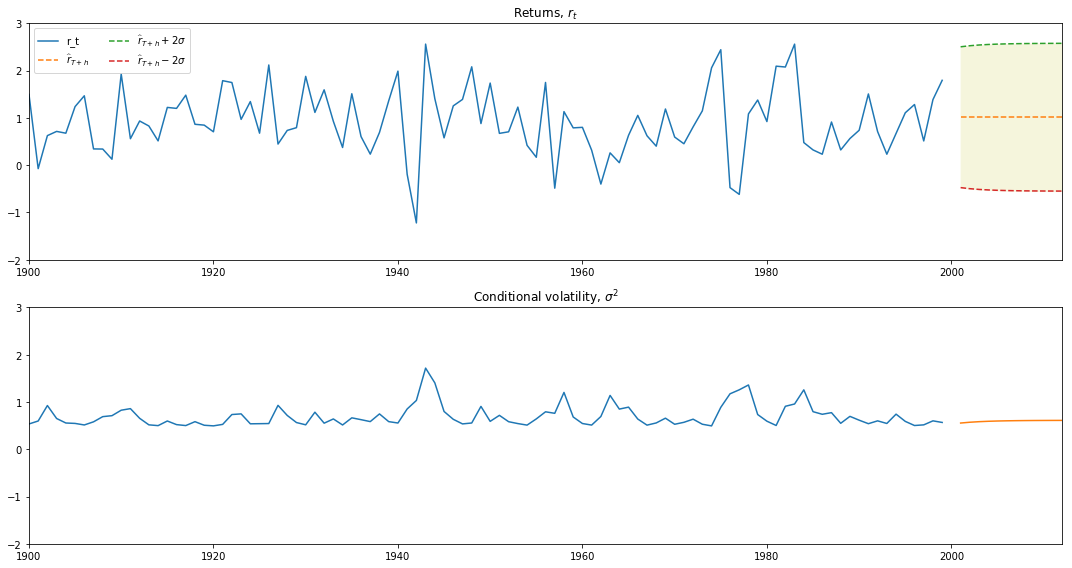

In [63]:
fig = plt.figure(figsize = (15, 8))
ax1 = fig.add_subplot(211)
ax1.plot(r_t, label = "r_t")
ax1.plot(forc_mean, linestyle ="--", label = "$\widehat{r}_{T+h}$")
ax1.plot(forc_mean + 2 * np.sqrt(mean_error), linestyle = "--", label = "$\widehat{r}_{T+h} + 2 \sigma$")
ax1.plot(forc_mean - 2 * np.sqrt(mean_error), linestyle = "--", label = "$\widehat{r}_{T+h} - 2 \sigma$")
ax1.fill_between(forc_mean.index, forc_mean - 2 * np.sqrt(mean_error), forc_mean + 2 * np.sqrt(mean_error), color = "beige")
#
plt.xlim(1900, len(r_t) + 12)
plt.ylim(-2, 3)
plt.legend(ncol = 2)
plt.title("Returns, $r_t$")
#
#
ax2 = fig.add_subplot(212)
ax2.plot(mdl_garch_fit.conditional_volatility, label = "Volatility")
ax2.plot(volatility_mean, label = "Volatility Forecast")
#
plt.xlim(1900, len(r_t) + 12)
plt.ylim(-2, 3)
plt.title("Conditional volatility, $\sigma^2$")
plt.tight_layout()
plt.show()

---

## Getting data from the internet

We can use the pandas_datareader package to get some sample data from the web using the Yahoo Finance API. [Package Page](https://anaconda.org/anaconda/pandas-datareader).

To install the package, follow the [documentation](https://pypi.org/project/arch/) - open your command prompt and enter the following:

```conda install -c anaconda pandas-datareader```

or, if you do not have anaconda, use ``pip install pandas-datareader``

Then we can load the required package:

In [64]:
import pandas_datareader.data as web

And download some stock data for specific date intervals. For example, we will get some `Google` stocks from `2010-01-01`, to `2019-01-01`

In [65]:
dt_start = '2010-01-01'
dt_end   = '2019-01-01'
GOOG = web.DataReader('GOOG', 'yahoo', start = dt_start, end = dt_end)

We can examine the downloaded dataset:

In [66]:
GOOG.head()

High         Low        Open       Close      Volume  \
Date                                                                     
2010-01-04  312.721039  310.103088  311.449310  311.349976   3937800.0   
2010-01-05  311.891449  308.761810  311.563568  309.978882   6048500.0   
2010-01-06  310.907837  301.220856  310.907837  302.164703   8009000.0   
2010-01-07  303.029083  294.410156  302.731018  295.130463  12912000.0   
2010-01-08  299.675903  292.651581  294.087250  299.064880   9509900.0   

             Adj Close  
Date                    
2010-01-04  311.349976  
2010-01-05  309.978882  
2010-01-06  302.164703  
2010-01-07  295.130463  
2010-01-08  299.064880

An adjusted closing price is a stock's closing price on any given day of trading that has been amended to include any distributions and corporate actions that occurred at any time before the next day's open. The adjusted closing price is often used when examining historical returns or performing a detailed analysis of historical returns.

We will take the `Adj Close` price and calculate the returns: $r_t = log(p_t) - log(p_{t-1})$.

$p_t$ can be exctracted as:

In [67]:
GOOG['Adj Close'].head()

Date
2010-01-04    311.349976
2010-01-05    309.978882
2010-01-06    302.164703
2010-01-07    295.130463
2010-01-08    299.064880
Name: Adj Close, dtype: float64

to get $p_{t-1}$ we need to `shift` the data so that at time `2010-01-05` we would have $p_{t-1} = p_{2010-01-04}$:

In [68]:
GOOG['Adj Close'].shift(1).head()

Date
2010-01-04           NaN
2010-01-05    311.349976
2010-01-06    309.978882
2010-01-07    302.164703
2010-01-08    295.130463
Name: Adj Close, dtype: float64

Combining both of these allows us to calculate the returns $r_t$ as:

In [69]:
returns = np.log(GOOG['Adj Close'] / GOOG['Adj Close'].shift(1)).dropna()
returns.head(10)

Date
2010-01-05   -0.004413
2010-01-06   -0.025532
2010-01-07   -0.023555
2010-01-08    0.013243
2010-01-11   -0.001513
2010-01-12   -0.017842
2010-01-13   -0.005758
2010-01-14    0.004690
2010-01-15   -0.016840
2010-01-19    0.013052
Name: Adj Close, dtype: float64

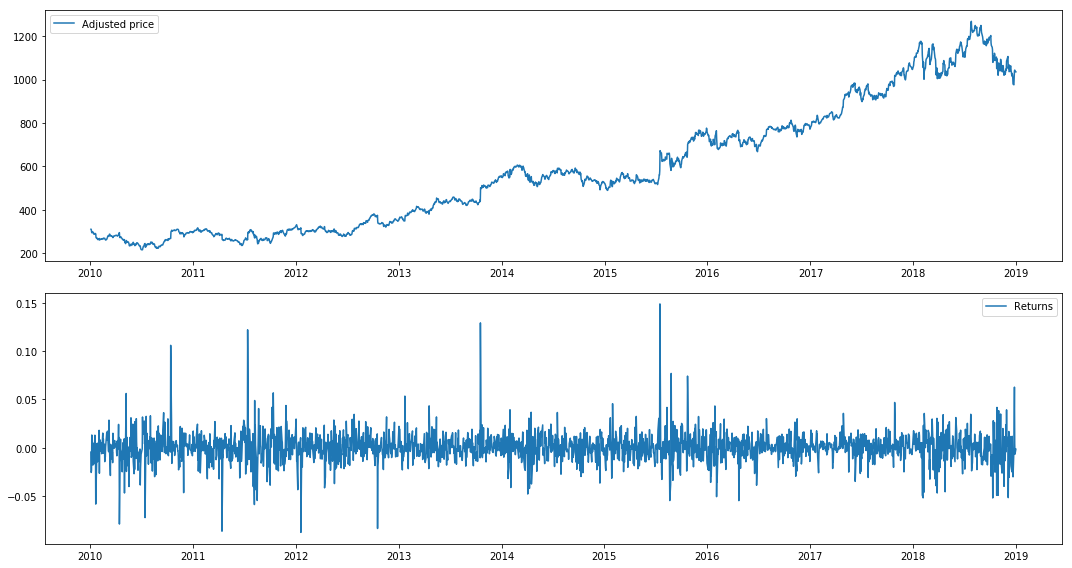

In [70]:
fig = plt.figure(figsize = (15, 8))
ax = fig.add_subplot(211)
ax.plot(GOOG['Adj Close'], label = "Adjusted price")
plt.legend()
ax = fig.add_subplot(212)
fig.add_subplot(212).plot(returns, label = "Returns")
plt.legend()
plt.tight_layout()
plt.show()

Note: In case you encounter any errors when fitting the model - from the [documentation](https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_scenarios.html):

    It is always a good idea to scale return by 100 before estimating ARCH-type models. 
    This helps the optimizer converse since the scale of the volatility intercept is 
    much closer to the scale of the other parameters in the model.
    
In other words, it may be better to have returns expressed in terms of percentages (%), i.e. multiplied by 100 - then the estimates will have a better chance of converging during the fitting of the model.

In order to succesfully estimate a model, we would need to repeat the previously provided steps to determine the relevant mean model, the possibility of $\rm ARCH$ effects and, if needed, the volatility model.